In [ ]:
import os
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from PIL import Image
import logging
# from UNET import UNet
from tqdm import tqdm
from torch import optim
from torch.utils.data import DataLoader

logging.basicConfig(format="%(asctime)s - %(levelname)s: %(message)s", level=logging.INFO, datefmt="%I:%M:%S")

In [ ]:
class Diffusion:
    def __init__(self, noise_steps = 500, beta_start = 1e-4, beta_end = 0.02, img_size = 256, device = "cuda"):
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device
        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim = 0)

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]#$.view(1, 1, None, None)
        Ɛ = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * Ɛ, Ɛ

    def sample_timesteps(self, n):
        return torch.randint(low = 1, high = self.noise_steps, size=(n,))

    def sample(self, model, labels, n, cfg_scale = 3):

        # The number of new images to sample.
        logging.info(f"Sampling {n} new images....")
        model.eval()

        with torch.no_grad(): # disables gradient calculations, which saves memory and computation

            x = torch.randn((n, 3, self.img_size, self.img_size)).to(self.device)  #x : tensor of random noise
            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):   # tqdm provides a progress bar for the loop, making it easier to track progress.
                t = (torch.ones(n) * i).long().to(self.device)
                # t = torch.tensor([i for _ in range(i)])
                predicted_noise = model(x, t, labels)

                if cfg_scale > 0:
                    uncond_predicted_noise = model(x, t, None)
                    predicted_noise = torch.lerp(uncond_predicted_noise, predicted_noise, cfg_scale)

                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]

                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)

                #denoising formula
                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise
        x = (x.clamp(-1, 1) + 1) / 2
        x = (x * 255).type(torch.uint8)   #convert image into png format
        model.train()
        return x

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os

source_file = '/content/models/ddpm_conditional_mnist/optim.pt'
destination_folder = '/content/drive/My Drive/Colab Notebooks/ddpm_conditional/model'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Copy the file to Google Drive
shutil.copy(source_file, destination_folder)


FileNotFoundError: [Errno 2] No such file or directory: '/content/models/ddpm_conditional_mnist/optim.pt'

In [ ]:
# class CustomImageDataset(Dataset):
#     def __init__(self, image_dir, transform=None):
#         self.image_dir = image_dir
#         self.image_files = [f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_files)

#     def __getitem__(self, idx):
#         img_name = os.path.join(self.image_dir, self.image_files[idx])
#         image = Image.open(img_name).convert("RGB")

#         if self.transform:
#             image = self.transform(image)

#         return image, 0

In [ ]:
# from torch.utils.data import DataLoader
# from tqdm import
def setup_logging(run_name):
    os.makedirs("models", exist_ok=True)
    os.makedirs("results", exist_ok=True)
    os.makedirs(os.path.join("models", run_name), exist_ok=True)
    os.makedirs(os.path.join("results", run_name), exist_ok=True)


def save_images(images, path, **kwargs):
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    im = Image.fromarray(ndarr)
    im.save(path)

    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    if ndarr.dtype != np.uint8:
        ndarr = (ndarr * 255).astype(np.uint8)
    print(ndarr.shape)
    im = Image.fromarray(ndarr)
    display(im)

class Gray(object):
    def __call__(self,img):
        return img.convert("RGB")

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, ConcatDataset

transform = torchvision.transforms.Compose([
    Gray(),
    torchvision.transforms.Resize((64, 64)),  
    torchvision.transforms.ToTensor(),        
    torchvision.transforms.Normalize(mean=[0, 0, 0],
                std=[1, 1, 1])
    ])
# car_dataset_train = torchvision.datasets.ImageFolder(root = 'stanford_cars/cars_train', transform=transform)
# car_dataset_test = torchvision.datasets.ImageFolder(root = 'stanford_cars/cars_test', transform=transform)
# combined_dataset = ConcatDataset([car_dataset_train, car_dataset_test])
# dataloader = DataLoader(combined_dataset, batch_size=40, shuffle=True)
dataset_train = torchvision.datasets.MNIST(root='.', train=True, transform=transform, download=True)
# face_dataset_train = torchvision.datasets.ImageFolder(root = r'E:\ddpm\humbnails128x128', transform=transform)
dataloader = DataLoader(dataset_train, batch_size=64, shuffle=True)

# dataloader
if dataloader:
    print("DataLoader successfully created!")
    print("Length of DataLoader:", len(dataloader.dataset))
    print("Batch size:", dataloader.batch_size)


DataLoader successfully created!
Length of DataLoader: 60000
Batch size: 64


In [ ]:
pbar = tqdm(dataloader)
for i, (images, p) in enumerate(pbar):
    print(images.shape)
    print("hello ",p)
    break

  0%|          | 0/938 [00:00<?, ?it/s]

torch.Size([64, 3, 64, 64])
hello  tensor([4, 6, 7, 2, 6, 1, 2, 9, 4, 3, 4, 8, 2, 2, 9, 7, 6, 7, 3, 2, 5, 1, 3, 0,
        0, 4, 8, 2, 0, 3, 7, 2, 4, 1, 8, 2, 5, 1, 9, 2, 4, 2, 0, 4, 5, 9, 2, 6,
        8, 9, 8, 7, 9, 5, 5, 7, 0, 7, 6, 8, 1, 7, 1, 4])


torch.Size([32, 3, 64, 64])
(266, 530, 3)


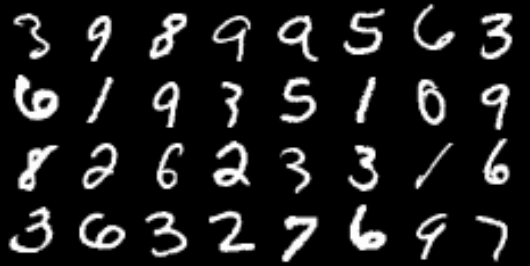

In [ ]:
# from IPython.display import display
import numpy as np
def save_images1(images, path, **kwargs):
    print(images.shape)
    grid = torchvision.utils.make_grid(images, **kwargs)
    ndarr = grid.permute(1, 2, 0).to('cpu').numpy()
    if ndarr.dtype != np.uint8:
        ndarr = (ndarr * 255).astype(np.uint8)
    print(ndarr.shape)
    im = Image.fromarray(ndarr)
    display(im)
    # im.save(path)
save_images1(images,'.')

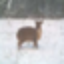

In [ ]:
to_pil = torchvision.transforms.ToPILImage()
to_pil(images[5])#Image.fromarray()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
def plot_images(images):
    plt.figure(figsize=(32, 32))
    plt.imshow(torch.cat([
        torch.cat([i for i in images.cpu()], dim=-1),
    ], dim=-2).permute(1, 2, 0).cpu())
    plt.show()

In [ ]:
import torch
epochs = 50
# from UNET import UNet
import numpy as np
run_name = 'ddpm_conditional_mnist'
num_classes = 10
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
lr = 1e-4
def train():
    setup_logging(run_name)
    # device = ''
    # dataloader = get_data(args)
    model = UNet_conditional(num_classes=num_classes, device=device).to(device)
    # model.load_state_dict(torch.load('models/gungun_cifar/ckpt.pt'))
    # # print("Model load success")
    # model.train()
    optimizer = optim.AdamW(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.6)

    mse = nn.MSELoss()
    diffusion = Diffusion(img_size=64, device=device,noise_steps=500)
    # logger = SummaryWriter(os.path.join("runs", run_name))
    l = len(dataloader)

    ema = EMA(0.995)
    ema_model = copy.deepcopy(model).eval().requires_grad_(False)

    for epoch in range(epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)
            #print(images.shape)
            t = diffusion.sample_timesteps(images.shape[0]).to(device)
            # print(t)
            x_t, noise = diffusion.noise_images(images, t)

            if np.random.random() < 0.1:
               labels = None
            # else:
            #    y = labels

            predicted_noise = model(x_t, t, labels)
            loss = mse(noise, predicted_noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            ema.step_ema(ema_model, model)


            pbar.set_postfix(MSE=loss.item())
            # logger.add_scalar("MSE", loss.item(), global_step=epoch * l + i)
        scheduler.step()

        # if epoch % 10 == 0:
        labels = torch.arange(10).long().to(device)
        sampled_images = diffusion.sample(model, n=len(labels), labels=labels)
        ema_sampled_images = diffusion.sample(ema_model, n=len(labels), labels=labels)

        if epoch % 5 == 0:
         plot_images(sampled_images)
        save_images(sampled_images, os.path.join("results", run_name, f"{epoch}.jpg"))
        save_images(ema_sampled_images, os.path.join("results", run_name, f"{epoch}_ema.jpg"))
        torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))
        torch.save(ema_model.state_dict(), os.path.join("models", run_name, f"ema_ckpt.pt"))
        torch.save(optimizer.state_dict(), os.path.join("models", run_name, f"optim.pt"))

        # sampled_images = diffusion.sample(model, n=images.shape[0])
        # save_images(sampled_images, os.path.join("results", run_name, f"{epoch}.jpg"))
        # torch.save(model.state_dict(), os.path.join("models", run_name, f"ckpt.pt"))

100%|██████████| 938/938 [06:34<00:00,  2.38it/s, MSE=0.0137]
499it [00:28, 17.24it/s]
499it [00:28, 17.23it/s]


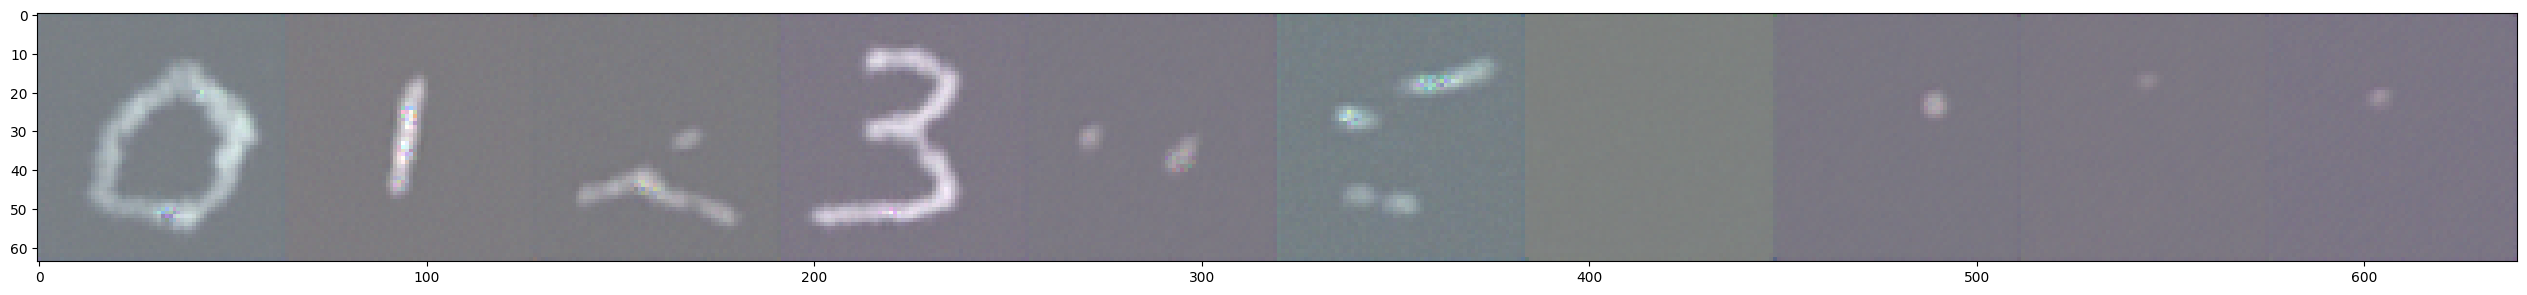

(134, 530, 3)


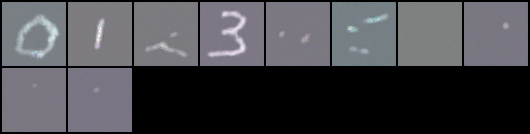

(134, 530, 3)


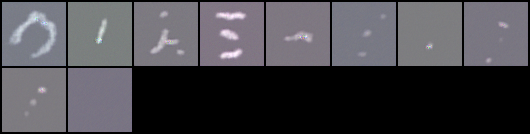

100%|██████████| 938/938 [06:38<00:00,  2.35it/s, MSE=0.01]
499it [00:28, 17.21it/s]
499it [00:28, 17.23it/s]


(134, 530, 3)


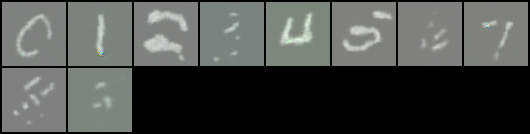

(134, 530, 3)


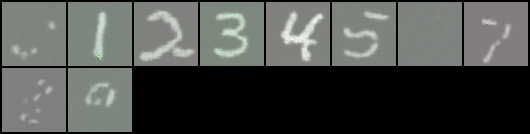

100%|██████████| 938/938 [06:41<00:00,  2.34it/s, MSE=0.0103]
499it [00:29, 16.88it/s]
499it [00:28, 17.23it/s]


(134, 530, 3)


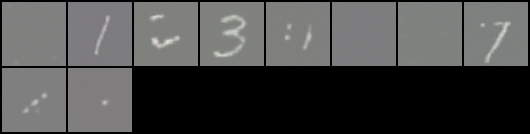

(134, 530, 3)


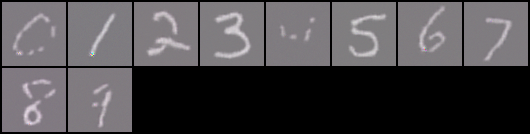

100%|██████████| 938/938 [06:42<00:00,  2.33it/s, MSE=0.007]
499it [00:28, 17.24it/s]
499it [00:28, 17.24it/s]


(134, 530, 3)


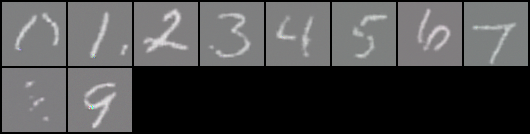

(134, 530, 3)


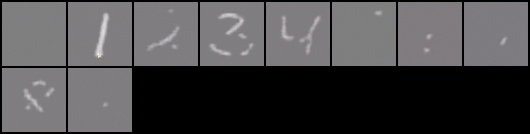

100%|██████████| 938/938 [06:41<00:00,  2.34it/s, MSE=0.00615]
499it [00:28, 17.24it/s]
499it [00:28, 17.24it/s]


(134, 530, 3)


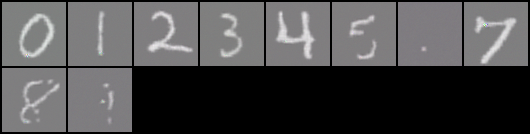

(134, 530, 3)


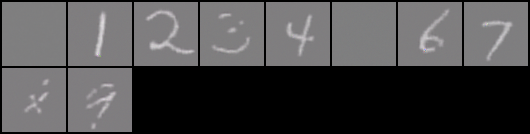

100%|██████████| 938/938 [06:42<00:00,  2.33it/s, MSE=0.00736]
499it [00:28, 17.23it/s]
499it [00:28, 17.24it/s]


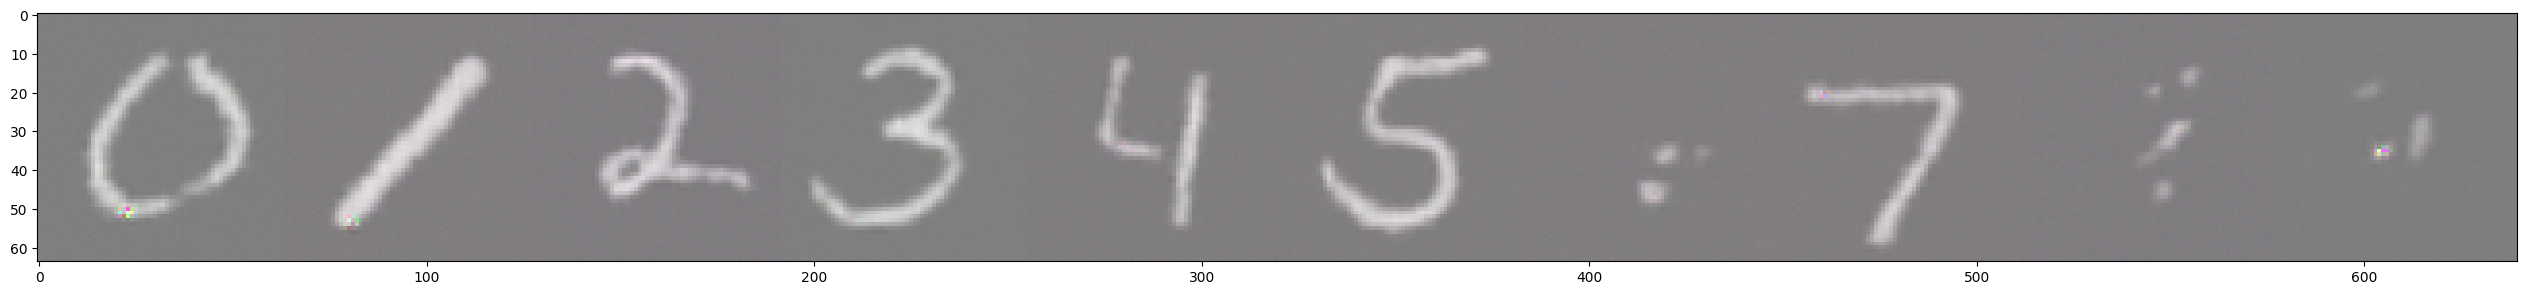

(134, 530, 3)


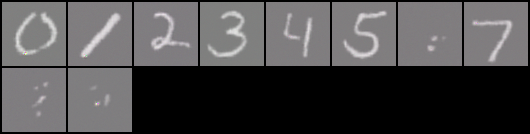

(134, 530, 3)


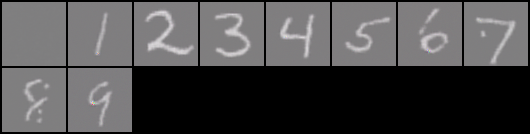

100%|██████████| 938/938 [06:42<00:00,  2.33it/s, MSE=0.00914]
499it [00:28, 17.24it/s]
499it [00:28, 17.22it/s]


(134, 530, 3)


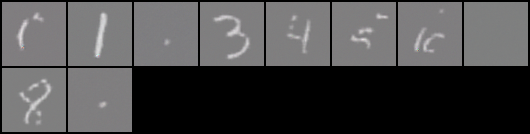

(134, 530, 3)


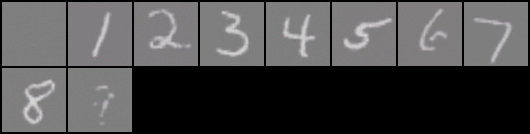

100%|██████████| 938/938 [06:42<00:00,  2.33it/s, MSE=0.00562]
499it [00:28, 17.22it/s]
499it [00:29, 17.19it/s]


(134, 530, 3)


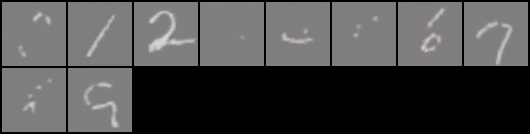

(134, 530, 3)


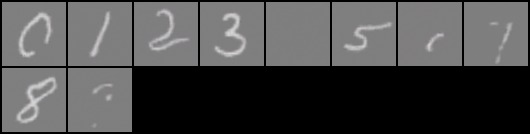

100%|██████████| 938/938 [06:43<00:00,  2.33it/s, MSE=0.00806]
499it [00:28, 17.24it/s]
499it [00:28, 17.23it/s]


(134, 530, 3)


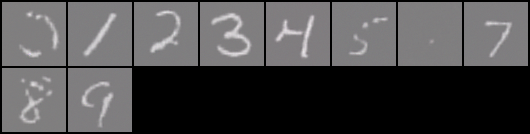

(134, 530, 3)


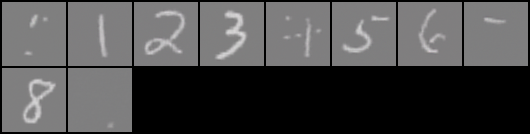

100%|██████████| 938/938 [06:42<00:00,  2.33it/s, MSE=0.00558]
499it [00:28, 17.21it/s]
499it [00:29, 17.20it/s]


(134, 530, 3)


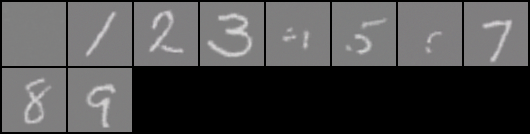

(134, 530, 3)


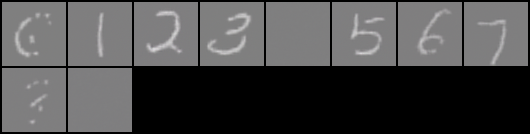

100%|██████████| 938/938 [06:43<00:00,  2.33it/s, MSE=0.00697]
499it [00:28, 17.23it/s]
499it [00:28, 17.23it/s]


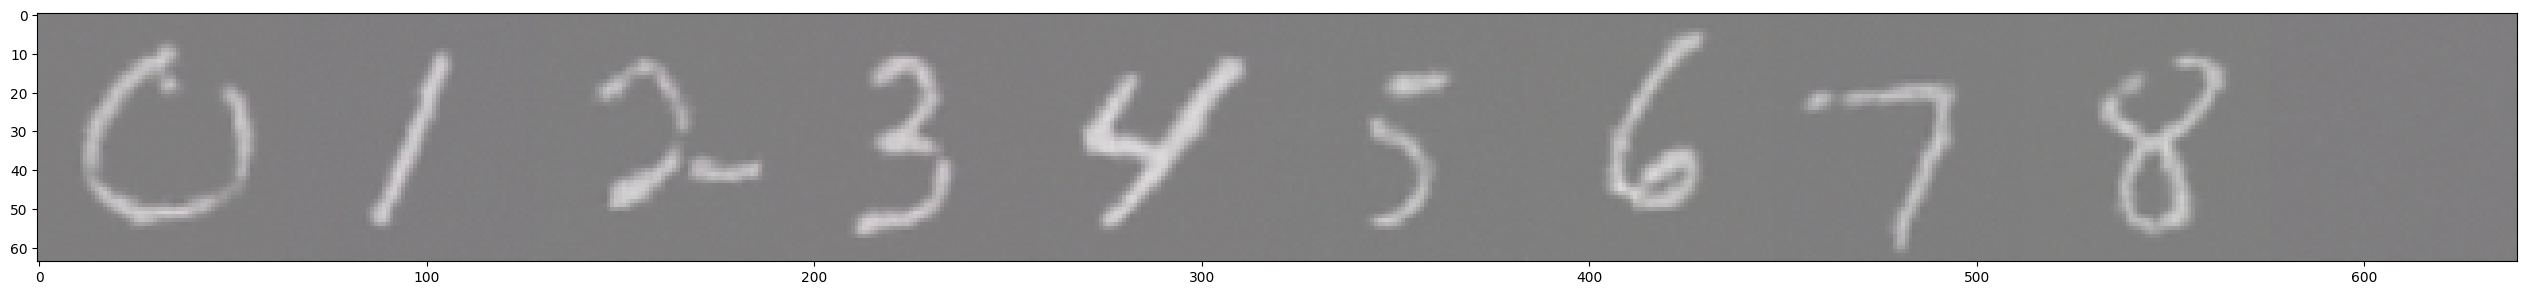

(134, 530, 3)


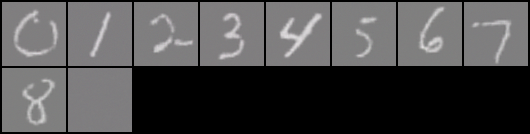

(134, 530, 3)


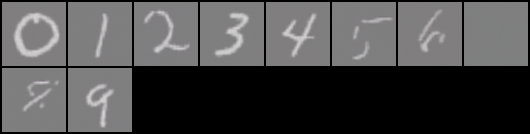

100%|██████████| 938/938 [06:43<00:00,  2.32it/s, MSE=0.00806]
499it [00:28, 17.23it/s]
499it [00:28, 17.23it/s]


(134, 530, 3)


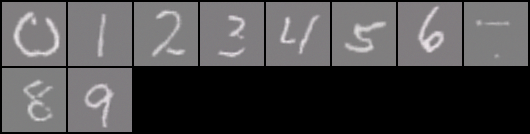

(134, 530, 3)


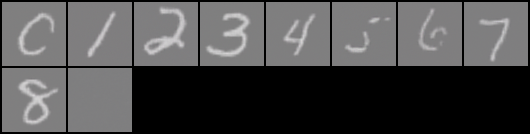

100%|██████████| 938/938 [06:42<00:00,  2.33it/s, MSE=0.00562]
499it [00:28, 17.23it/s]
499it [00:28, 17.22it/s]


(134, 530, 3)


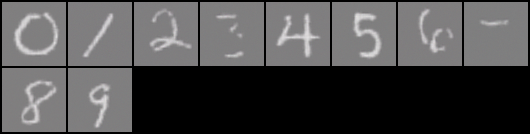

(134, 530, 3)


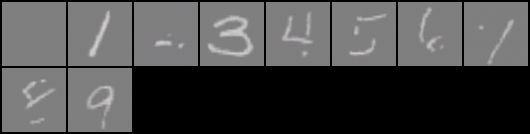

100%|██████████| 938/938 [06:42<00:00,  2.33it/s, MSE=0.0067]
499it [00:28, 17.22it/s]
499it [00:28, 17.22it/s]


(134, 530, 3)


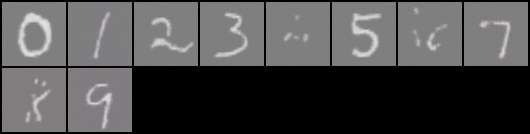

(134, 530, 3)


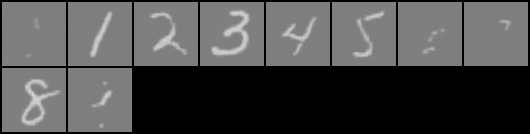

 20%|█▉        | 187/938 [01:20<05:23,  2.32it/s, MSE=0.00881]


KeyboardInterrupt: 

In [ ]:
import copy
train()


In [ ]:
images.shape

torch.Size([30, 3, 28, 28])

In [ ]:
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self,x):
        g1 = self.W_g(x)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi


In [ ]:
class EMA:
    def __init__(self, beta):
        super().__init__()
        self.beta = beta
        self.step = 0

    def update_model_average(self, ma_model, current_model):
        for current_params, ma_params in zip(current_model.parameters(), ma_model.parameters()):
            old_weight, up_weight = ma_params.data, current_params.data
            ma_params.data = self.update_average(old_weight, up_weight)

    def update_average(self, old, new):
        if old is None:
            return new
        return old * self.beta + (1 - self.beta) * new

    def step_ema(self, ema_model, model, step_start_ema=2000):
        if self.step < step_start_ema:
            self.reset_parameters(ema_model, model)
            self.step += 1
            return
        self.update_model_average(ema_model, model)
        self.step += 1

    def reset_parameters(self, ema_model, model):
        ema_model.load_state_dict(model.state_dict())


In [ ]:
# %%
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image


# %%
class DoubleConv(nn.Module):
    def __init__ (self, in_channels, out_channels, mid_channels = None, residual = False):
        super(). __init__()
        self.residual = residual
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(nn.Conv2d(in_channels,mid_channels,kernel_size = 3, padding = 1, bias = False),
                                     nn.GroupNorm(16,mid_channels),
                                     nn.GELU(),
                                     nn.Conv2d(mid_channels,out_channels,kernel_size = 3, padding = 1, bias = False),
                                     nn.GroupNorm(16,out_channels),
                                     nn.GELU(),
        )

    def forward(self, x):
        if self.residual:
            return F.gelu(x + self.double_conv(x))
        else:
           return self.double_conv(x)


class Down(nn.Module):
    def __init__ (self, in_channels, out_channels, emb_dim = 256):
        super(). __init__()
        self.down_conv = nn.Sequential(nn.MaxPool2d(kernel_size = 2), #decrease spatial dimensions by half
                                  DoubleConv(in_channels, in_channels, residual=True), #No of channels remains same when residual true
                                  DoubleConv(in_channels, out_channels),

        )

        self.down_emb = nn.Sequential(nn.SiLU(),
                                      nn.Linear(emb_dim,out_channels))

    def forward(self, x, t):
        x = self.down_conv(x)
        emb = self.down_emb(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])

        return x+emb

# %%
class Up(nn.Module):
    def __init__(self, in_channels,out_channels,emb_dim = 256):
         super(). __init__()
         self.unsample = nn.Upsample(scale_factor = 2, mode = 'bilinear', align_corners = True)  #increase h,w by scale_factor
         self.up_conv = nn.Sequential( DoubleConv(in_channels, in_channels, residual=True),
                                  DoubleConv(in_channels, out_channels, in_channels // 2)) #n_channels // 2 bcoz due to concat channels increases

         self.up_emb = nn.Sequential(nn.SiLU(),
                                      nn.Linear(emb_dim,out_channels))

    def forward(self, x, skip_x, t):
        # #print("upsampling",x.shape)
        x = self.unsample(x)   #increase spatial dimensions by double
        x = torch.cat([x,skip_x], dim = 1) # x and the skip_x have same spatial dimensions but dfrnt channels.
                                           #Concat along the channel dimension (dim=1) ensures that the features from both tensors are combined
                                           # channel-wise, preserving the spatial information.
        x = self.up_conv(x)
        emb = self.up_emb(t)[:, :, None, None].repeat(1, 1, x.shape[-2], x.shape[-1])
        return  x + emb

class UNet1(nn.Module):
    def __init__(self, c_in=3, c_out=3, time_dim=256, device="cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.input_conv = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        # self.sa1 = Attention_block(128,128,128)
        self.down2 = Down(128, 256)
        # self.sa2 = Attention_block(256,256,256)
        self.down3 = Down(256, 256)
        self.sa3 = Attention_block(256,256,256)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = Attention_block(128,128,128)
        #self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = Attention_block(64,64,64)
        #self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = Attention_block(64,64,64)
        #self.sa6 = SelfAttention(64, 64)
        self.outc = nn.Conv2d(64, c_out, kernel_size = 1)


    def pos_encoding(self,t):
            channels = self.time_dim
            inv_freq  = 1.0 / (
                10000
                ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
            )
            pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
            pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
            pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
            return pos_enc

    def forward(self, x, t):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t)

        x1 = self.input_conv(x)
        x2 = self.down1(x1, t)
        # x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        # x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4_sa = self.sa3(x4,x4)
        x4 = x4_sa+x4

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x,x)+x # explicitely one skip to be added.

        x = self.up2(x, x2, t)
        x = self.sa5(x,x)+x
        x = self.up3(x, x1, t)
        x = self.sa6(x,x)+x
        output = self.outc(x)
        return output


In [ ]:
class UNet_conditional(nn.Module):
    def __init__(self, c_in = 3, c_out = 3, time_dim = 256, num_classes = None, device = "cuda"):
        super().__init__()
        self.device = device
        self.time_dim = time_dim
        self.inc = DoubleConv(c_in, 64)
        self.down1 = Down(64, 128)
        # self.sa1 = SelfAttention(128, 32)
        self.down2 = Down(128, 256)
        # self.sa2 = SelfAttention(256, 16)
        self.down3 = Down(256, 256)
        # self.sa3 = SelfAttention(256, 8)
        self.sa3 = Attention_block(256,256,256)

        self.bot1 = DoubleConv(256, 512)
        self.bot2 = DoubleConv(512, 512)
        self.bot3 = DoubleConv(512, 256)

        self.up1 = Up(512, 128)
        self.sa4 = Attention_block(128,128,128)
        # self.sa4 = SelfAttention(128, 16)
        self.up2 = Up(256, 64)
        self.sa5 = Attention_block(64,64,64)
        # self.sa5 = SelfAttention(64, 32)
        self.up3 = Up(128, 64)
        self.sa6 = Attention_block(64,64,64)
        self.outc = nn.Conv2d(64, c_out, kernel_size=1)

        if num_classes is not None:
            self.label_emb = nn.Embedding(num_classes, time_dim)

    def pos_encoding(self, t, channels):
        inv_freq = 1.0 / (
            10000
            ** (torch.arange(0, channels, 2, device=self.device).float() / channels)
        )
        pos_enc_a = torch.sin(t.repeat(1, channels // 2) * inv_freq)
        pos_enc_b = torch.cos(t.repeat(1, channels // 2) * inv_freq)
        pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
        return pos_enc

    def forward(self, x, t, y):
        t = t.unsqueeze(-1).type(torch.float)
        t = self.pos_encoding(t, self.time_dim)

        if y is not None:
            t += self.label_emb(y)

        x1 = self.inc(x)
        x2 = self.down1(x1, t)
        # x2 = self.sa1(x2)
        x3 = self.down2(x2, t)
        # x3 = self.sa2(x3)
        x4 = self.down3(x3, t)
        x4 = self.sa3(x4)

        x4 = self.bot1(x4)
        x4 = self.bot2(x4)
        x4 = self.bot3(x4)

        x = self.up1(x4, x3, t)
        x = self.sa4(x)
        x = self.up2(x, x2, t)
        x = self.sa5(x)
        x = self.up3(x, x1, t)
        x = self.sa6(x)
        output = self.outc(x)
        return output

In [ ]:
model = UNet1()
x = torch.randn((5,3,64,64))
t = torch.randint(1000,(5,))
#.to(device)
t
# mha = nn.MultiheadAttention(embed_dim = 768, num_heads = 4, batch_first = True)


tensor([ 71, 755, 226,  29, 405])

In [ ]:
model = UNet1()
x = torch.randn((5,3,64,64))
t = torch.randint(1000,(5,))
#.to(device)
t
# model(x,t).shape

torch.Size([5, 256, 8, 8])


torch.Size([5, 3, 64, 64])

In [ ]:
x = torch.randn((5,256,64,64))


In [ ]:
class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi



In [ ]:
dataset_path = r"C:\Users\hp\Downloads\archive\cars_test"
car_dataset = torchvision.datasets.ImageFolder(root = dataset_path, transform=transforms)
dataloader_2 = DataLoader(car_dataset, batch_size=8, shuffle=True)


In [ ]:
if dataloader_2:
    print("DataLoader successfully created!")
    print("Length of DataLoader:", len(dataloader_2.dataset))
    print("Batch size:", dataloader_2.batch_size)

DataLoader successfully created!
Length of DataLoader: 8041
Batch size: 8
